# Deep Convolutional Generative Adversial Nueral Network (DCGANS) GPU Optimized Code

In [ ]:
# Imports
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn, optim
from matplotlib import pyplot as plt
import seaborn as sns
import torch.jit as jit

Checks For CUDA Device

In [ ]:
#checks if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
ngpu = 1 # set to zero if u want cpu 
norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# image param per data set
batch_size = 64
image_size = 64

#transfomrers data into a tensor
transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
])

## Loads Data Set and sets up labels

In [ ]:
from torchvision import datasets

# loads dataset and preps for GPU
dataset = datasets.ImageFolder(root="/data/art",transform=transf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

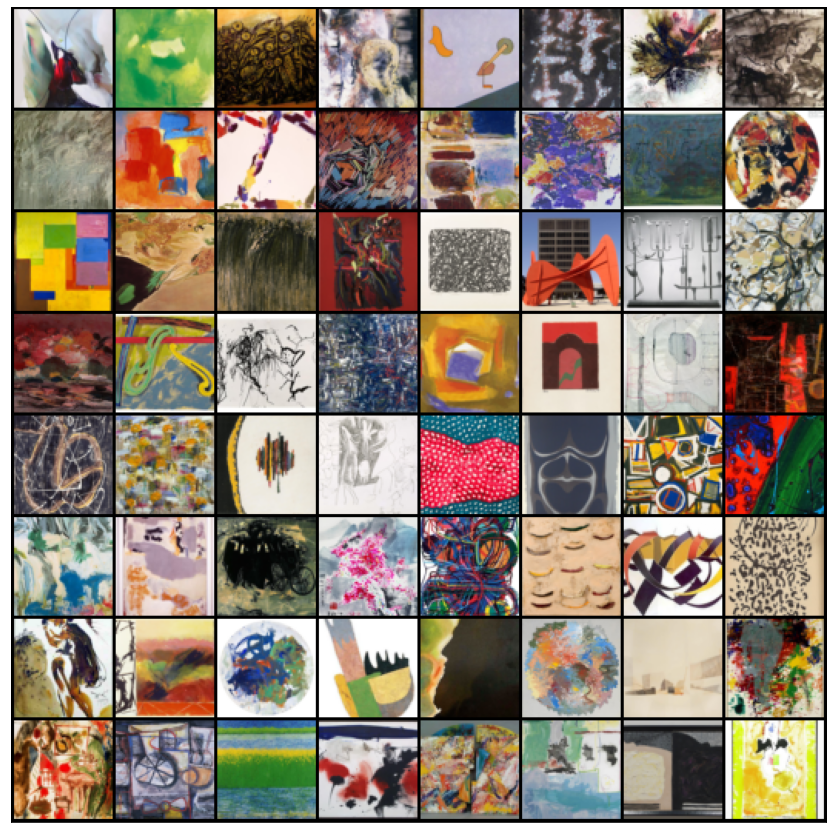

In [ ]:
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, *norm)
        ax.imshow(make_grid(unnorm_images[:batch_size], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
show_batch(dataloader)

## Loads Initial Weights
Weights come from the DCGANs Paper

In [ ]:
# custom weights initialization called on netG and netD
# From the DCGAN Paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## The Generator Code

The decorator @jit.script_method is used for converting Python -> Torchscript

In [1]:
#from torch.nn.parallel import DistributedDataParallel as DDP
# Generator Code
import torch.jit as jit
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

nz = 100
ngf = 64
nc = 3

#enviornment variable to enable benchamarked Convolution layer
torch.backends.cudnn.benchmark = True

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size.  4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size.  8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size.  16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size.  32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size.  64 x 64
        )
    
    @jit.script_method
    def forward(self, input):
        return self.main(input)

modelG = Generator(1).to(device)

# for 1 gpu 
# CUDA Data Parallelized
if(ngpu == 1):
    modelG = nn.DataParallel(modelG, list(range(ngpu)))
else:
    # For multiple GPUs
    # DDP (Data Distributed Parallel)
    modelG = DDP(modelG, list(range(ngpu)))


modelG.apply(weights_init)
print(modelG)

NameError: name 'torch' is not defined

## Discriminator Code

In [ ]:
nz = 100
ndf = 64
nc = 3
# 8 is the factor were looking for

# The same are generator except in reverse
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size.  32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    @jit.script_method
    def forward(self, input):
        return self.main(input)
modelD = Discriminator(1)
modelD.to(device)

# for 1 gpu 
# CUDA Data Parallelized
if(ngpu == 1):
    modelD = nn.DataParallel(modelG, list(range(ngpu)))
else: # DDP
    modelD = DDP(modelG, list(range(ngpu)))


modelD.apply(weights_init)

DataParallel(
  (module): DataParallel(
    (module): DataParallel(
      (module): Generator(
        (main): Sequential(
          (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
          (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (8): ReLU(inplace=True)
          (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

## Loss Function Code 

$\min_{G}\max_{D}\mathbb{E}_{x\sim p_{\text{data}}(x)}[\log{D(x)}] +  \mathbb{E}_{z\sim p_{\text{z}}(z)}[1 - \log{D(G(z))}]$


In [ ]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.0
fake_label = 0.0

# "Better" extension to gradient descent for CV
optimizerD = optim.Adam(modelD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(modelG.parameters(), lr=0.0001, betas=(0.5, 0.999))

## Training 

Disclaimer: This takes 2 hours to run so scroll down for some results

In [ ]:
import torchvision.utils as vutils

# These imports are needed for some envionrments
#from PIL import Image, ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

img_list = []
G_losses, D_losses = [], []
total = 0
epoch_count = 100 #number of iterations done
for epoch in range(epoch_count):
    g_loss = 0.0
    d_loss = 0.0
    D_x = 0.0
    D_G_z1 = 0.0
    D_G_z2 = 0.0
    
    for i, data in enumerate(dataloader, 0):
        
        modelD.zero_grad() #initialize autograd for iteration
        real_cpu = data[0].to(device) # move to device
        b_size = real_cpu.size(0) # gets the size 
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)  
        output = modelD(real_cpu).view(-1) 
        errD_real = criterion(output, label) # loss function
        errD_real.backward() # computes gradient
        D_x += output.mean().item()
        noise = torch.randn(b_size, 100, 1, 1, device=device) # adds noise on device 

        fake = modelG(noise) 
        label.fill_(fake_label) # fills tensor with labels 
        output = modelD(fake.detach()).view(-1) #judges last one 
        errD_fake = criterion(output, label) # loss funcition calculation
        errD_fake.backward() # compute gradient
        D_G_z1 += output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step() # 1 optimization step 

        modelG.zero_grad() # resets gradient
        label.fill_(real_label)
        output = modelD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward() # computes gradient of tensor
        D_G_z2 += output.mean().item()
        optimizerG.step() # 1 optimization step
        # add loss for calc
        g_loss += errG.item()
        d_loss += errD.item()
        total += b_size
        
    avg_g_loss = g_loss / total
    G_losses.append(avg_g_loss)
    avg_d_loss = d_loss / total
    D_losses.append(avg_d_loss)
    
    avg_D_x = D_x / len(dataloader)
    avg_D_G_z1 = D_G_z1 / len(dataloader)
    avg_D_G_z2 = D_G_z2 / len(dataloader)
    
    print('Epoch: {} \tDiscriminator Loss: {:.6f} \tGenerator Loss: {:.6f} \tD(x): {:.6f} \tD(G(z)): {:.6f} / {:.6f}'.format(
        epoch + 1,
        avg_d_loss,
        avg_g_loss,
        avg_D_x,
        avg_D_G_z1,
        avg_D_G_z2
    ))
    
    with torch.no_grad():
        fake = modelG(fixed_noise).detach().cpu() # shallow copy on cpu from gpu
    img_list.append(vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True))
    

print('Finished Training')

Epoch: 1 	Discriminator Loss: 0.008622 	Generator Loss: 0.086869 	D(x): 0.806420 	D(G(z)): 0.215006 / 0.013192
Epoch: 2 	Discriminator Loss: 0.001101 	Generator Loss: 0.062670 	D(x): 0.939970 	D(G(z)): 0.064185 / 0.000596
Epoch: 3 	Discriminator Loss: 0.000303 	Generator Loss: 0.042328 	D(x): 0.974769 	D(G(z)): 0.028367 / 0.000419


KeyboardInterrupt: ignored

Saves Model

In [ ]:
# Saves the "Weights"
torch.save(modelG.state_dict(), 'G1.pth')
torch.save(modelD.state_dict(), 'D1.pth')

RecursiveScriptModule(
  original_name=Generator
  (main): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=ConvTranspose2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=ConvTranspose2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=ConvTranspose2d)
    (7): RecursiveScriptModule(original_name=BatchNorm2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=ConvTranspose2d)
    (10): RecursiveScriptModule(original_name=BatchNorm2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=ConvTranspose2d)
    (13): RecursiveScriptModule(original_name=Tanh)
  )
)

In [ ]:
#modelG = Generator(1)
#modelD = Discriminator(1)

#modelG = torch.load('model/G.pth')
#modelD = torch.load('model/D.pth')


Makes animation of images trained from

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[::6]]
ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=250, blit=True)

HTML(ani.to_jshtml())

Sample Image from already trained model on 200 epochs

In [6]:
from IPython.display import Image
Image(url="sample(1).png",width=100, height=100)